In [1]:
from requests_html import AsyncHTMLSession
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<!DOCTYPE html>
<html lang="en">
 <head>
  <script async="" src="https://www.clarity.ms/eus2/s/0.6.31/clarity.js">
  </script>
  <script async="" src="https://analytics.tiktok.com/i18n/pixel/config.js?sdkid=C5JO5ONGE0M3SF4JTO3G&amp;hostname=www.carvana.com" type="text/javascript">
  </script>
  <script src="https://ext.chtbl.com/trackable.js">
  </script>
  <script async="" src="//scripts.kissmetrics.com/570eca152b48daaad3766730e8aebfa6f644ee87.2.js" type="text/javascript">
  </script>
  <script async="" src="//i.kissmetrics.com/i.js" type="text/javascript">
  </script>
  <script async="" src="https://analytics.tiktok.com/i18n/pixel/events.js?sdkid=C5JO5ONGE0M3SF4JTO3G&amp;lib=ttq" type="text/javascript">
  </script>
  <script async="" src="https://cdn.branch.io/branch-latest.min.js">
  </script>
  <script async="" src="https://d.impactradius-event.com/A2458437-a526-42e6-b075-e733344a281a1.js">
  </script>
  <script async="" src="https://c.hrzn-nxt.com/js/v2.12.0/connect.min.js">
  </s
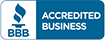

In [2]:
from requests_html import AsyncHTMLSession
URL = 'https://www.carvana.com/cars'
asession = AsyncHTMLSession()
response = await asession.get(URL)
await response.html.arender(wait=2, timeout=100)
soup = BeautifulSoup(response.html.html, 'lxml')
print(soup.prettify())

In [3]:
print(soup.find_all('div', {'class': 'ResultsCountstyles__ResultsCountWrapper-sc-1igkx7j-0 jKoXak'})[0].find('p').text)
print('Pages:', soup.find('span', {'data-cv-test': 'Cv.Search.Pagination.CurrentPageDisplay'}).text[10:])

Results: 75,098
Pages: 3577


In [4]:
frame = []

for page in range(1, 4):
    print(f"{page=}")
    
    URL = f"https://www.carvana.com/cars?page={page}"
    response = await asession.get(URL)  # async loading
    print(response.status_code)
    await response.html.arender(wait=2, timeout=100)
    soup = BeautifulSoup(response.html.html, 'lxml')
    print(f"loaded page {page}")
    
    for car_id, \
        year_model, \
        make_miles, \
        price, \
        monthly, \
        down_payment, \
        shipping \
    in zip(
        [card.find('a')['href'][9:] for card in soup.find_all('div', {'class': 'result-tile'})],
        soup.find_all('div', {'class': 'year-make-experiment'}), 
        soup.find_all('div', {'class': 'trim-mileage'}), 
        soup.find_all('div', {'class': 'price-variant'}), 
        [i for i in soup.find_all('span', {'class': 'tooltip-anchor'}) if '$' in i], 
        soup.find_all('div', {'class': 'down-payment'}),
        soup.find_all('span', {'class': 'delivery'})
    ):
#         print(f"{year_model.text} -- {make_miles.text[:make_miles.text.index('•') - 1]}, {make_miles.text[make_miles.text.index('•') + 2:]} -- {price.text} -- {monthly.text} -- {down_payment.text} -- {shipping.text}")
        data = [  # year, model, make, miles, price, monthly payment, cash down, shipping
            car_id,
            int(year_model.text[:4]),
            year_model.text[5:].split(' ')[0],
            year_model.text[5:],
            make_miles.text[:make_miles.text.index('•') - 1].capitalize() if make_miles.text[:make_miles.text.index('•') - 1] == 'base' else make_miles.text[:make_miles.text.index('•') - 1],
            int(make_miles.text[make_miles.text.index('•') + 2:][:-6].replace(',', '')),
            int(price.text[1:].replace(',', '')),
            int(monthly.text[1:-3]),
            int(down_payment.text[1:-9]),
            int(shipping.text[11:])
        ]
        frame.append(data)
    
cars = pd.DataFrame(frame, columns=['ID', 'Year', 'Brand', 'Make', 'Model', 'Miles', '$ Price', '$ Monthly Payment', '$ Cash Down', '$ Shipping'])
display(cars)

page=1
200
loaded page 1
page=2
200
loaded page 2
page=3
200
loaded page 3


,ID,Year,Brand,Make,Model,Miles,$ Price,$ Monthly Payment,$ Cash Down,$ Shipping
0,2167605,2015,Mazda,Mazda CX-5,Touring,81954,19990,359,0,599
1,2167604,2013,Ford,Ford Mustang,V6 Premium,14258,24590,421,0,599
2,2061875,2017,Honda,Honda Civic,LX,42022,20590,354,0,599
3,2087757,2019,Ford,Ford Fiesta,SE,22704,17990,309,0,599
4,2106960,2015,Volkswagen,Volkswagen Passat,1.8T SE,64523,17990,311,0,599
...,...,...,...,...,...,...,...,...,...,...
58,2103429,2013,Nissan,Nissan Pathfinder,SV,94755,18990,342,0,599
59,2167778,2012,Honda,Honda CR-V,EX,39351,21590,371,0,599
60,2130653,2021,Kia,Kia Rio,S,8369,22590,386,0,599
61,2042445,2015,Chevrolet,Chevrolet Equinox,LT,76522,20990,363,0,599


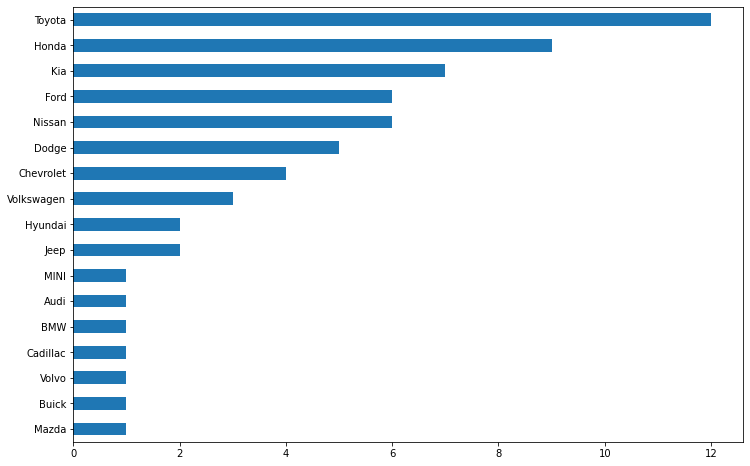

In [5]:
plt.figure(figsize=(12, 8))
cars['Brand'].value_counts(ascending=True).plot.barh()
plt.show()